## Imports and Utilities

In [1]:
import numpy as np
from itertools import product
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from tqdm import tqdm

In [49]:
def plot_gen_hooks_example(fn_type = 'circle'):
    dist_between_hooks_pixels = 70
    rectangle_width = 0.3
    rectangle_height = 0.2  
    wheel_pixel_size = 3500
    wheel_real_size = np.sqrt(rectangle_width**2 + rectangle_height**2)
    rectangle_height_pixels = (rectangle_height / wheel_real_size) * wheel_pixel_size
    rectangle_width_pixels = (rectangle_width / wheel_real_size) * wheel_pixel_size
    hook_real_size = 6 * (10**-3)
    hook_pixel_size = (hook_real_size / wheel_real_size) * wheel_pixel_size
    n_hooks = int(2 * (np.floor(rectangle_width_pixels / dist_between_hooks_pixels) + np.floor(rectangle_height_pixels / dist_between_hooks_pixels)))

    if fn_type == 'circle':
        # n_hooks, wheel_pixel_size, hook_pixel_size
        kwargs = {'n_hooks': n_hooks, 'wheel_pixel_size': wheel_pixel_size, 'hook_pixel_size': hook_pixel_size}
        generate_hooks = generate_hooks_circle
    elif fn_type == 'rect':
        # dist_between_hooks_pixels, side_pixel_size1, side_pixel_size2, hook_pixel_size
        kwargs = {'dist_between_hooks_pixels': dist_between_hooks_pixels, 'side_pixel_size1': rectangle_width_pixels, 'side_pixel_size2': rectangle_height_pixels, 'hook_pixel_size': hook_pixel_size}
        generate_hooks = generate_hooks_rect
    elif fn_type == 'prism':
        # dist_between_hooks, side_size1, side_size2, side_size3, hook_size
        kwargs = {'dist_between_hooks': dist_between_hooks_pixels, 'side_size1': rectangle_width_pixels, 'side_size2': rectangle_height_pixels, 'side_size3': 1.4 * rectangle_height_pixels, 'hook_size': hook_pixel_size}
        n_hooks = int(2 * (np.floor(rectangle_width_pixels / dist_between_hooks_pixels) + np.floor(rectangle_height_pixels / dist_between_hooks_pixels) + np.floor(rectangle_height_pixels / dist_between_hooks_pixels)))
        generate_hooks = generate_hooks_prism
    else: 
        print('Invalid function type')
        return
    
    hooks = generate_hooks(**kwargs)

    brightness = np.linspace(1, 0, len(hooks))  # Brighter (1) to darker (0)

    plt.figure(figsize=(6, 6))
    plt.scatter(hooks[:, 0], hooks[:, 1], s=5, c=brightness, cmap='gray')
    plt.title("Generated Hooks for Rectangle with Brightness Gradient")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.colorbar(label='Brightness (Earlier Hooks are Brighter)')
    plt.show()

## Generate Hookses

**generate_hooks**     
* Generates the position of hooks, given a particular number of hooks, wheel pixel size, and hook pixel size.
* Creates 2 lists of positions (one for the anticlockwise side, one for the clockwise), and weaves them together so that the order they appear in the final output is the order of nodes anticlockwise around the frame.

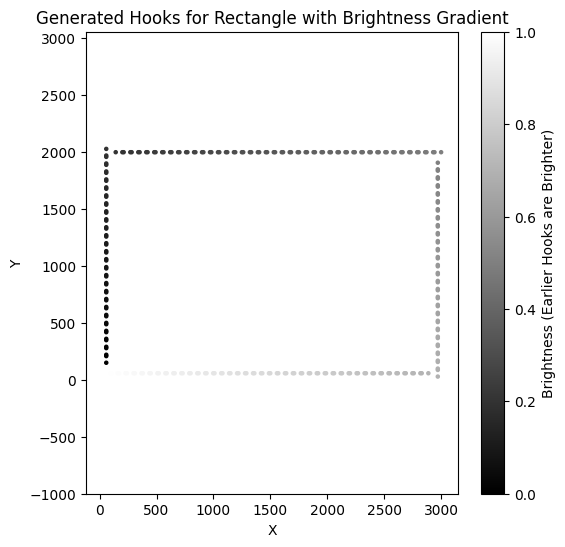

In [4]:
def generate_hooks_rect(dist_between_hooks_pixels, side_pixel_size1, side_pixel_size2, hook_pixel_size):
    d = dist_between_hooks_pixels
    s1 = side_pixel_size1
    s2 = side_pixel_size2

    n_hooks = 2 * (np.floor(s1 / d) + np.floor(s2 / d))
    eps = hook_pixel_size / 2

    ax1 = d * np.arange(np.floor(s1 / d))
    # minus / plus 
    ax1_plus = ax1 + eps
    ax1_minus = ax1 - eps
    # interleaving:
    ax1 = np.stack((ax1_minus, ax1_plus)).ravel(order='F')

    ax2 = d * np.arange(np.floor(s2 / d))
    # minus / plus
    ax2_plus = ax2 + eps
    ax2_minus = ax2 - eps
    # interleaving:
    ax2 = np.stack((ax2_minus, ax2_plus)).ravel(order='F')

    side1 = np.stack((ax1, np.zeros_like(ax1))).T
    side4 = np.stack((np.full_like(ax2, s1), ax2)).T
    # flip to make it consistently clockwise / counterclockwise
    side3 = np.stack((s1 - ax1, np.full_like(ax1, s2))).T
    side2 = np.stack((np.zeros_like(ax2), s2 - ax2)).T 

    hooks = np.concatenate((side1, side4, side3, side2), axis=0)
    
    np.random.seed(0)
    # rot = np.random.randn(2, 2) / 2.5

    # hooks = np.matmul(hooks, rot)  # oopsies a bit of rotation! 

    # increase y by the minimum y value, so that the minimum y value is 0
    hooks[:, 1] -= hooks[:, 1].min() - eps
    # increase x by the minimum x value, so that the minimum x value is 0
    hooks[:, 0] -= hooks[:, 0].min() - eps
    
    return hooks

plot_gen_hooks_example('rect')


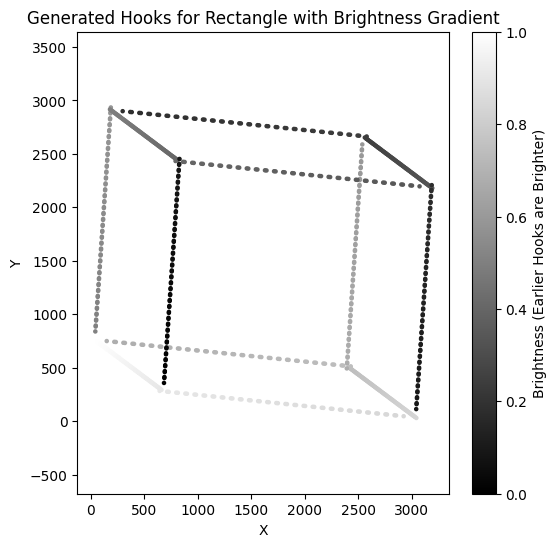

In [50]:
def generate_hooks_prism(dist_between_hooks, side_size1, side_size2, side_size3, hook_size):
    d = dist_between_hooks
    s1 = side_size1
    s2 = side_size2
    s3 = side_size3

    n_hooks = 2 * (np.floor(s1 / d) + np.floor(s2 / d) + np.floor(s3 / d))
    eps = hook_size / 2

    ax1 = d * np.arange(np.floor(s1 / d))
    # minus / plus 
    ax1_plus = ax1 + eps
    ax1_minus = ax1 - eps
    # interleaving:
    ax1 = np.stack((ax1_minus, ax1_plus)).ravel(order='F')

    ax2 = d * np.arange(np.floor(s2 / d))
    # minus / plus
    ax2_plus = ax2 + eps
    ax2_minus = ax2 - eps
    # interleaving:
    ax2 = np.stack((ax2_minus, ax2_plus)).ravel(order='F')

    ax3 = d * np.arange(np.floor(s3 / d))
    # minus / plus
    ax3_plus = ax3 + eps
    ax3_minus = ax3 - eps
    # interleaving:
    ax3 = np.stack((ax3_minus, ax3_plus)).ravel(order='F')
    side1 = np.stack((ax1, np.zeros_like(ax1), np.zeros_like(ax1))).T
    side6 = np.stack((np.full_like(ax2, s1), ax2, np.zeros_like(ax2))).T
    side5 = np.stack((s1 - ax1, np.full_like(ax1, s2), np.zeros_like(ax1))).T
    side4 = np.stack((np.zeros_like(ax2), s2 - ax2, np.zeros_like(ax2))).T
    side7 = np.stack((ax1, np.zeros_like(ax1), np.full_like(ax1, s3))).T
    side8 = np.stack((np.full_like(ax2, s1), ax2, np.full_like(ax2, s3))).T
    side9 = np.stack((s1 - ax1, np.full_like(ax1, s2), np.full_like(ax1, s3))).T
    
    side10 = np.stack((np.zeros_like(ax2), s2 - ax2, np.full_like(ax2, s3))).T 
    side2 = np.stack((np.zeros_like(ax3), np.zeros_like(ax3), s3 - ax3)).T
    side3 = np.stack((np.zeros_like(ax3), np.full_like(ax3, s2), ax3)).T    
    side11 = np.stack((np.full_like(ax3, s1), np.full_like(ax3, s2), s3 - ax3)).T
    side12 = np.stack((np.full_like(ax3, s1), np.zeros_like(ax3), s3 - ax3)).T

    hooks = np.concatenate((side1, side6, side5, side4, side3, side2, side7, side8, side9, side10, side11, side12), axis=0)
    
    np.random.seed(5)
    rot = np.random.randn(3, 2) / 2

    hooks = np.matmul(hooks, rot)  # oopsies a bit of rotation! 

    # # now, with hooks in 2D, we will choose a center
    # center = hooks.mean(axis=0)
    # # and then we will sort by angle, so that the hooks are in order
    # angles = np.arctan2((hooks - center)[:, 1], (hooks - center)[:, 0])
    # hooks = hooks[np.argsort(angles)]

    # increase y by the minimum y value, so that the minimum y value is 0
    hooks[:, 1] -= hooks[:, 1].min() - eps
    # increase x by the minimum x value, so that the minimum x value is 0
    hooks[:, 0] -= hooks[:, 0].min() - eps
    
    return hooks
    
plot_gen_hooks_example('prism')

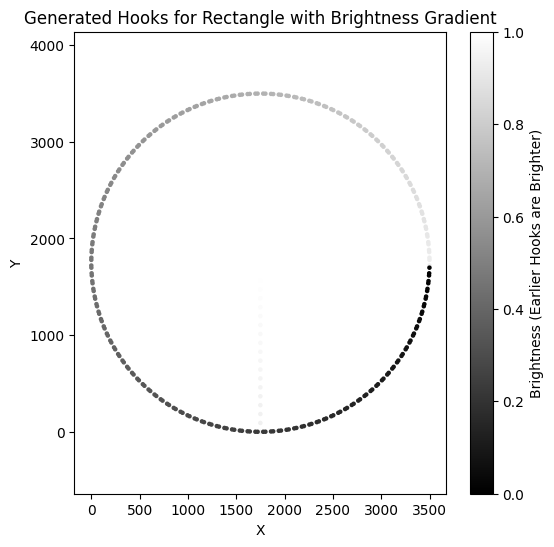

In [5]:
def generate_hooks_circle(n_hooks, wheel_pixel_size, hook_pixel_size):
    
    r = (wheel_pixel_size / 2) - 1
    
    theta = np.arange(n_hooks, dtype="float64") / n_hooks * (2 * np.pi)
    
    epsilon = np.arcsin(hook_pixel_size / wheel_pixel_size)
    
    theta_acw = theta.copy() + epsilon
    theta_cw = theta.copy() - epsilon
    
    theta = np.stack((theta_cw, theta_acw)).ravel("F")
    
    x = r * (1 + np.cos(theta)) + 0.5
    y = r * (1 + np.sin(theta)) + 0.5

    output = np.array((x,y)).T

    # add a straight line through the center

    # adding an interpolation from the center point (r, r) to (r, 0)
    line = np.stack((np.full_like(theta[:20], r), np.linspace(r, 0, len(theta[:20])))).T
    output = np.concatenate((line, output), axis=0)


    return output

plot_gen_hooks_example('circle')

## Through Pixels and Through Pixels Dict

**through_pixels**
* Given 2 hooks, generates a list of pixels that the line connecting them runs through.

**build_through_pixels_dict**
* Uses `through_pixels` to build up a dictionary of all possible lines connecting 2 hooks.
* Can be run at the start of a project, and doesn't need to be run again.
* Prints out an ongoing estimate of how much time is left.

In [35]:
def through_pixels(p0, p1):
    
    d = max(int(((p0[0]-p1[0])**2 + (p0[1]-p1[1])**2) ** 0.5), 1)
    
    pixels = p0 + (p1-p0) * np.array([np.arange(d+1), np.arange(d+1)]).T / d
    pixels = np.unique(np.round(pixels), axis=0).astype(int)
    
    return pixels


def build_through_pixels_dict(n_hooks, rectangle_width, rectangle_height, dist_between_hooks_pixels):
    n_hook_sides = n_hooks * 2

    print(f"n_hooks = {n_hooks}")
    print(hooks.shape)

    n_hooks_ax1 = np.floor(rectangle_width / dist_between_hooks_pixels) * 2
    n_hooks_ax2 = np.floor(rectangle_height / dist_between_hooks_pixels) * 2

    l = [(0,1)]
    for j in tqdm(range(n_hook_sides)):
        # determine which side the hook is on, then iterate through all hooks on other sides 
        # start = 0
        # dist = n_hook_sides - n_hooks_ax2
        # if j < n_hooks_ax1:
        #     start = n_hooks_ax1
        #     dist = n_hook_sides - n_hooks_ax1
        # elif j < n_hooks_ax1 + n_hooks_ax2:
        #     start = n_hooks_ax1 + n_hooks_ax2
        #     dist = n_hook_sides - n_hooks_ax2 # wrap around
        # elif j < n_hooks_ax1 + n_hooks_ax2 + n_hooks_ax1:
        #     start = n_hooks_ax1 + n_hooks_ax2 + n_hooks_ax1
        #     dist = n_hook_sides - n_hooks_ax1

        # for i in range(int(start), int(start + dist)):
        #     if np.abs(i - j) < 5: break # too close to itself
        #     i = i % n_hook_sides
        #     if np.abs(i - j) < 5: break
        #     l.append((i,j))
        for i in range(j):
            l.append((i,j))
    
    random_order = np.random.choice(len(l),len(l),replace=False)
    
    d = {}    
    # t_list = []
    # t0 = time.time()
    
    for n in tqdm(range(len(l))):
        (i, j) = l[random_order[n]]
        p0, p1 = hooks[i], hooks[j]
        d[(i,j)] = through_pixels(p0, p1)
        
        # t = time.time() - t0
        # t_left = t * (len(l) - n - 1) / (n + 1)
        # print(f"time left = {time.strftime('%M:%S', time.gmtime(t_left))}", end="\r")
    
    clear_output()
    return d

## Fitness and Optimise Fitness

**fitness**
* Measures how much a line improves the image. 
* Improvement is difference in penalty between the old and new images (i.e. a large decrease in penalty means a large fitness value).
* Penalty depends on the lightness_penalty, w, w_pos, w_neg and line_norm_mode parameters, however it is always some kind of weighted average of the absolute values of the pixels in the image. 

**optimise_fitness**
* Process of adding a new line is as follows:
    1. Generates all possible lines starting from this hook (or a subset of lines, if you are using the `time_saver` parameter). 
    2. Finds the line with the best fitness score.
    2. Subtracts this line from the image.
    3. Returns the new image, and the best line.

In [8]:
def fitness(image, line, darkness, lp, w, w_pos, w_neg, line_norm_mode):
    
    pixels = through_pixels_dict[tuple(sorted(line))]
    
    old_pixel_values = image[tuple(pixels.T)]
    new_pixel_values = old_pixel_values - darkness

    if type(w) == bool and type(w_pos) == bool:
        new_penalty = new_pixel_values.sum() - (1 + lp) * new_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_pixel_values.sum() - (1 + lp) * old_pixel_values[old_pixel_values < 0].sum()
    elif type(w_pos) == bool:
        pixel_weightings = w[tuple(pixels.T)]
        new_w_pixel_values = new_pixel_values * pixel_weightings
        old_w_pixel_values = old_pixel_values * pixel_weightings
        new_penalty = new_w_pixel_values.sum() - (1 + lp) * new_w_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_w_pixel_values.sum() - (1 + lp) * old_w_pixel_values[old_pixel_values < 0].sum()
    elif type(w) == bool:
        pos_pixel_weightings = w_pos[tuple(pixels.T)]
        neg_pixel_weightings = w_neg[tuple(pixels.T)]
        new_wpos_pixel_values = new_pixel_values * pos_pixel_weightings
        new_wneg_pixel_values = new_pixel_values * neg_pixel_weightings
        old_wpos_pixel_values = old_pixel_values * pos_pixel_weightings
        old_wneg_pixel_values = old_pixel_values * neg_pixel_weightings
        new_penalty = new_wpos_pixel_values[new_pixel_values > 0].sum() - lp * new_wneg_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_wpos_pixel_values[old_pixel_values > 0].sum() - lp * old_wneg_pixel_values[old_pixel_values < 0].sum()

    if line_norm_mode == "length":
        line_norm = len(pixels)
    elif line_norm_mode == "weighted length":
        if type(w_pos) == bool:
            line_norm = pixel_weightings.sum()
        else:
            line_norm = pos_pixel_weightings.sum()
    elif line_norm_mode == "none":
        line_norm = 1
        
    if line_norm == 0:
        return 0
    else:
        return (old_penalty - new_penalty) / line_norm


def optimise_fitness(image, previous_edge, darkness, lightness_penalty, list_of_lines, 
                     w, w_pos, w_neg, line_norm_mode, time_saver):
    
    if previous_edge % 2 == 0:
        starting_edge = previous_edge + 1
    else:
        starting_edge = previous_edge - 1
          
    sides_A = np.ones(n_hooks * 2) * starting_edge
    sides_B = np.arange(n_hooks * 2)
    next_lines = np.stack((sides_A, sides_B)).ravel("F").reshape((n_hooks * 2, 2)).astype(int)
    mask = (np.abs(next_lines.T[1] - next_lines.T[0]) > 10) & (np.abs(next_lines.T[1] - next_lines.T[0]) < n_hooks * 2 - 10)
    next_lines = next_lines[mask]
    
    if time_saver == 1:
        next_lines = next_lines.tolist()
    else:
        next_lines = next_lines[np.random.choice(np.arange(len(next_lines)), int(len(next_lines) * time_saver))].tolist()

    fitness_list = [fitness(image, line, darkness, lightness_penalty, w, w_pos, w_neg, line_norm_mode) for line in next_lines]
    best_line_idx = fitness_list.index(max(fitness_list))
    best_line = next_lines[best_line_idx]

    pixels = through_pixels_dict[tuple(sorted(best_line))]
    image[tuple(pixels.T)] -= darkness
    
    return image, best_line

### Find Lines and Get Penalty

**find_lines**
* Calls `optimise_fitness` multiple times to draw a set of lines.
* Updates the image and the list of lines with each line drawn.
* Every 100 lines drawn, prints output that describes the progress of the algorithm (including average penalty, current runtime, and projected total runtime).

**get_penalty**
* Calculates the total penalty of the image.
* This is different depending on whether importance weightings are being used.

In [9]:
def find_lines(image, n_lines, darkness, lightness_penalty, line_norm_mode, w=False, w_pos=False, w_neg=False, time_saver=1):
    
    list_of_lines = []
    previous_edge = np.random.choice(n_hooks * 2)
    
    image_copy = image.copy()
    
    for i in range(n_lines):
        
        if i == 0:
            t0 = time.time()
            initial_penalty = get_penalty(image_copy, lightness_penalty, w, w_pos, w_neg)
            initial_avg_penalty = f'{initial_penalty / (wheel_pixel_size ** 2):.2f}'
        elif i%100 == 0:
            t_so_far = time.strftime('%M:%S', time.gmtime(time.time() - t0))
            t_left = time.strftime('%M:%S', time.gmtime((time.time() - t0) * (n_lines - i) / i))   
            penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
            avg_penalty = f'{penalty / (wheel_pixel_size ** 2):.2f}'
            print(f"{i}/{n_lines}, average penalty = {avg_penalty}/{initial_avg_penalty}, \
time = {t_so_far}, time left = {t_left}    ", end="\r")                
        
        image, line = optimise_fitness(image_copy, previous_edge, darkness, lightness_penalty, list_of_lines, 
                                       w, w_pos, w_neg, line_norm_mode, time_saver)
        previous_edge = line[1]
        
        list_of_lines.append(line)

    
    clear_output()
    
    penalty = get_penalty(image_copy, lightness_penalty, w, w_pos, w_neg)
    avg_penalty = f'{penalty / (wheel_pixel_size ** 2):.2f}'
    print(f"{len(list_of_lines)}/{n_lines}, average penalty = {avg_penalty}/{initial_avg_penalty}")
    print("time = " + time.strftime('%M:%S', time.gmtime(time.time() - t0)))
    
    return list_of_lines
        

def get_penalty(image, lightness_penalty, w, w_pos, w_neg):
    
    if type(w) == bool and type(w_pos) == bool:
        return image.sum() - (1 + lightness_penalty) * image[image<0].sum()
    elif type(w_pos) == bool:
        image_w = image * w
        return image_w.sum() - (1 + lightness_penalty) * image_w[image<0].sum()
    elif type(w) == bool:
        image_wpos = image * w_pos
        image_wneg = image * w_neg
        return image_wpos[image>0].sum() - lightness_penalty * image_wneg[image<0].sum() 

## Image Generation

**prepare_image**
* Takes a jpeg or png image file, and converts it into a square array of bytes.
* `colour` (boolean) determines whether image is meant to have its colour read rather than darkness. If True then the pixel values will represent the saturation of the image, if False then they will represent the darkness.
* `weighting` (boolean) determines whether image is meant to be an importance weighting. If True, the array has values between 0 and 1, where black = 1 = maximum importance, and white = 0 = no importance).

**display_images**
* Displays images (i.e. output from `prepare_image`) inline, in a nice format.

In [10]:
def prepare_image(file_name, colour=False, weighting=False):
    
    image = Image.open(file_name).resize((wheel_pixel_size, wheel_pixel_size))
    
    if colour:
        image = np.array(image.convert(mode="HSV").getdata()).reshape((wheel_pixel_size, wheel_pixel_size,3))[:,:,1]
    elif weighting:     
        image = 1 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size, wheel_pixel_size)) / 255
    else:
        image = 255 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size, wheel_pixel_size))
    
    coords = np.array(list(product(range(wheel_pixel_size), range(wheel_pixel_size))))
    x_coords = coords.T[0]
    y_coords = coords.T[1]
    coords_distance_from_centre = np.sqrt((x_coords - (wheel_pixel_size-1)*0.5)**2 + (y_coords - (wheel_pixel_size-1)*0.5)**2)
    mask = np.array(coords_distance_from_centre > wheel_pixel_size*0.5)
    mask = np.reshape(mask, (-1, wheel_pixel_size))
    image[mask] = 0                             
    
    return image.T[:,::-1]


def display_images(image_list):
    
    fig, axs = plt.subplots(1,len(image_list),figsize=(30,30));
    for (i,j) in zip(range(len(image_list)), image_list):
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].imshow(j[:,::-1].T, cmap=plt.get_cmap("Greys"));

**save_plot**
* Saves the plot of lines as a jpeg with a specified name.
* It can also save multicoloured images; colours are added in the order they appear in the list.
* The colour tuples are interpreted using RGB format.

**save_plot_progress**
* Saves multiple plots midway through the construction process.
* `proportion_list` contains a list of floats between 0 and 1, representing the proportion of lines you want to draw (e.g. if the list was \[0.5,1\], then 2 plots would be saved, one with half the lines drawn and one completely finished.

In [11]:
def save_plot(list_coloured_lines, list_colours, file_name, size):
        
    new_hooks = generate_hooks(**kwargs)
    
    for i in range(len(new_hooks)):
        new_hooks[i] = [new_hooks[i][0], size - new_hooks[i][1]]
    
    thread_image = Image.new('RGB', (size,size), (255,255,255))
    draw = ImageDraw.Draw(thread_image)

    # Make lines completely random choices instead
    # remove random seed? 
    # np.random.seed(None)
    # randoms = np.random.choice(len(new_hooks), (len(list_coloured_lines), 2))
    # lines = [(randoms[i][0], randoms[i][1]) for i in range(len(randoms))]

    for (lines, colour) in zip(list_coloured_lines, list_colours):
        def safe_access(new_hooks, indices):
            try:
                return (new_hooks[indices[0]], new_hooks[indices[1]])
            except IndexError:
                return None

        pixel_pairs = [pair for pair in (safe_access(new_hooks, n) for n in lines) if pair is not None]
        for j in pixel_pairs:
            draw.line((tuple(j[0]), tuple(j[1])), fill=colour)
        
    thread_image.save(file_name + ".jpg", format="JPEG")
    
    
def save_plot_progress(list_coloured_lines, list_colours, file_name, size, proportion_list):
    
    for prop in proportion_list:
        file_name_temp = f"{file_name} {int(100*prop)}%"
        lines_temp = list_coloured_lines[-1][:int(len(list_coloured_lines[-1])*prop)]
        list_coloured_lines_temp = list_coloured_lines[:-1] + [lines_temp]
        save_plot(list_coloured_lines_temp, list_colours, file_name_temp, size=size)

**total_distance**
* Prints out the total distance of thread needed to make the model (in meters).

**display_output**
* Prints out the lines in a form that can be interpreted (used for manual threading).

In [12]:
def total_distance(lines):
    
    d = 0
    for line in lines:
        hook_A, hook_B = hooks[line[0]], hooks[line[1]]
        d += ((hook_A[0]-hook_B[0])**2 + (hook_A[1]-hook_B[1])**2) ** 0.5 + hook_pixel_size
    
    d = d * (wheel_real_size / wheel_pixel_size)
    
    print(f"distance = {int(d)} meters")   

    
def display_output(lines):
    
    print(f"{lines[0][0]//2}-{lines[0][0]%2}")
    for i in range(len(lines)):
        if i%100 == 0 and i>0:
            print(f"\n{i}\n")
        line = lines[i]
        output_number = f"{line[1]//2}-{line[1]%2}"
        print(output_number)

## Running the Program

In [53]:
dist_between_hooks_pixels = 70
rectangle_width = 0.3
rectangle_height = 0.2  
wheel_pixel_size = 3500
wheel_real_size = np.sqrt(rectangle_width**2 + rectangle_height**2)
rectangle_height_pixels = (rectangle_height / wheel_real_size) * wheel_pixel_size
rectangle_width_pixels = (rectangle_width / wheel_real_size) * wheel_pixel_size
hook_real_size = 6 * (10**-3)
hook_pixel_size = (hook_real_size / wheel_real_size) * wheel_pixel_size
n_hooks = int(2 * (np.floor(rectangle_width_pixels / dist_between_hooks_pixels) + np.floor(rectangle_height_pixels / dist_between_hooks_pixels)))

fn_type = 'prism'

if fn_type == 'circle':
    # n_hooks, wheel_pixel_size, hook_pixel_size
    kwargs = {'n_hooks': n_hooks, 'wheel_pixel_size': wheel_pixel_size, 'hook_pixel_size': hook_pixel_size}
    generate_hooks = generate_hooks_circle
elif fn_type == 'rect':
    # dist_between_hooks_pixels, side_pixel_size1, side_pixel_size2, hook_pixel_size
    kwargs = {'dist_between_hooks_pixels': dist_between_hooks_pixels * 1.45, 'side_pixel_size1': wheel_pixel_size * 0.9, 'side_pixel_size2': wheel_pixel_size * 0.9, 'hook_pixel_size': hook_pixel_size}
    generate_hooks = generate_hooks_rect
    # calculate n_hooks from kwargs
    n_hooks = int(2 * (np.floor(kwargs['side_pixel_size1'] / kwargs['dist_between_hooks_pixels']) + np.floor(kwargs['side_pixel_size2'] / kwargs['dist_between_hooks_pixels'])))
elif fn_type == 'prism':
    # dist_between_hooks, side_size1, side_size2, side_size3, hook_size
    kwargs = {'dist_between_hooks': dist_between_hooks_pixels * 2, 'side_size1': rectangle_width_pixels, 'side_size2': rectangle_height_pixels, 'side_size3': 1.4 * rectangle_height_pixels, 'hook_size': hook_pixel_size}
    generate_hooks = generate_hooks_prism
    # calculate n_hooks from kwargs
    n_hooks = int(4 * (np.floor(kwargs['side_size1'] / kwargs['dist_between_hooks']) + np.floor(kwargs['side_size2'] / kwargs['dist_between_hooks']) + np.floor(kwargs['side_size3'] / kwargs['dist_between_hooks'])))
else: 
    print('Invalid function type')

hooks = generate_hooks(**kwargs)

print(hooks.shape)
print("____")
through_pixels_dict = build_through_pixels_dict(n_hooks, rectangle_width, rectangle_height, dist_between_hooks_pixels)

In [54]:
image_BLACK = prepare_image("tiger_face_BLACK.jpg")
image_ORANGE = prepare_image("tiger_face_ORANGE.jpg", colour=True)
image_w = prepare_image("tiger_face_weighting.jpg", weighting=True)

In [55]:
lines_BLACK = find_lines(image_BLACK, n_lines=3000, 
                         darkness=160, lightness_penalty=0.55, 
                         w=image_w, line_norm_mode="length",
                         time_saver=0.5)

3000/3000, average penalty = 42.37/52.13
time = 00:47


In [56]:
lines_ORANGE = find_lines(image_ORANGE, n_lines=2000, 
                          darkness=210, lightness_penalty=0.7, 
                          w=image_w, line_norm_mode="length",
                          time_saver=0.5)

2000/2000, average penalty = 42.75/51.70
time = 00:30


In [57]:
save_plot([lines_ORANGE, lines_BLACK], [(255,130,0), (0,0,0)], "tiger output", 3500)

## For once it's functional

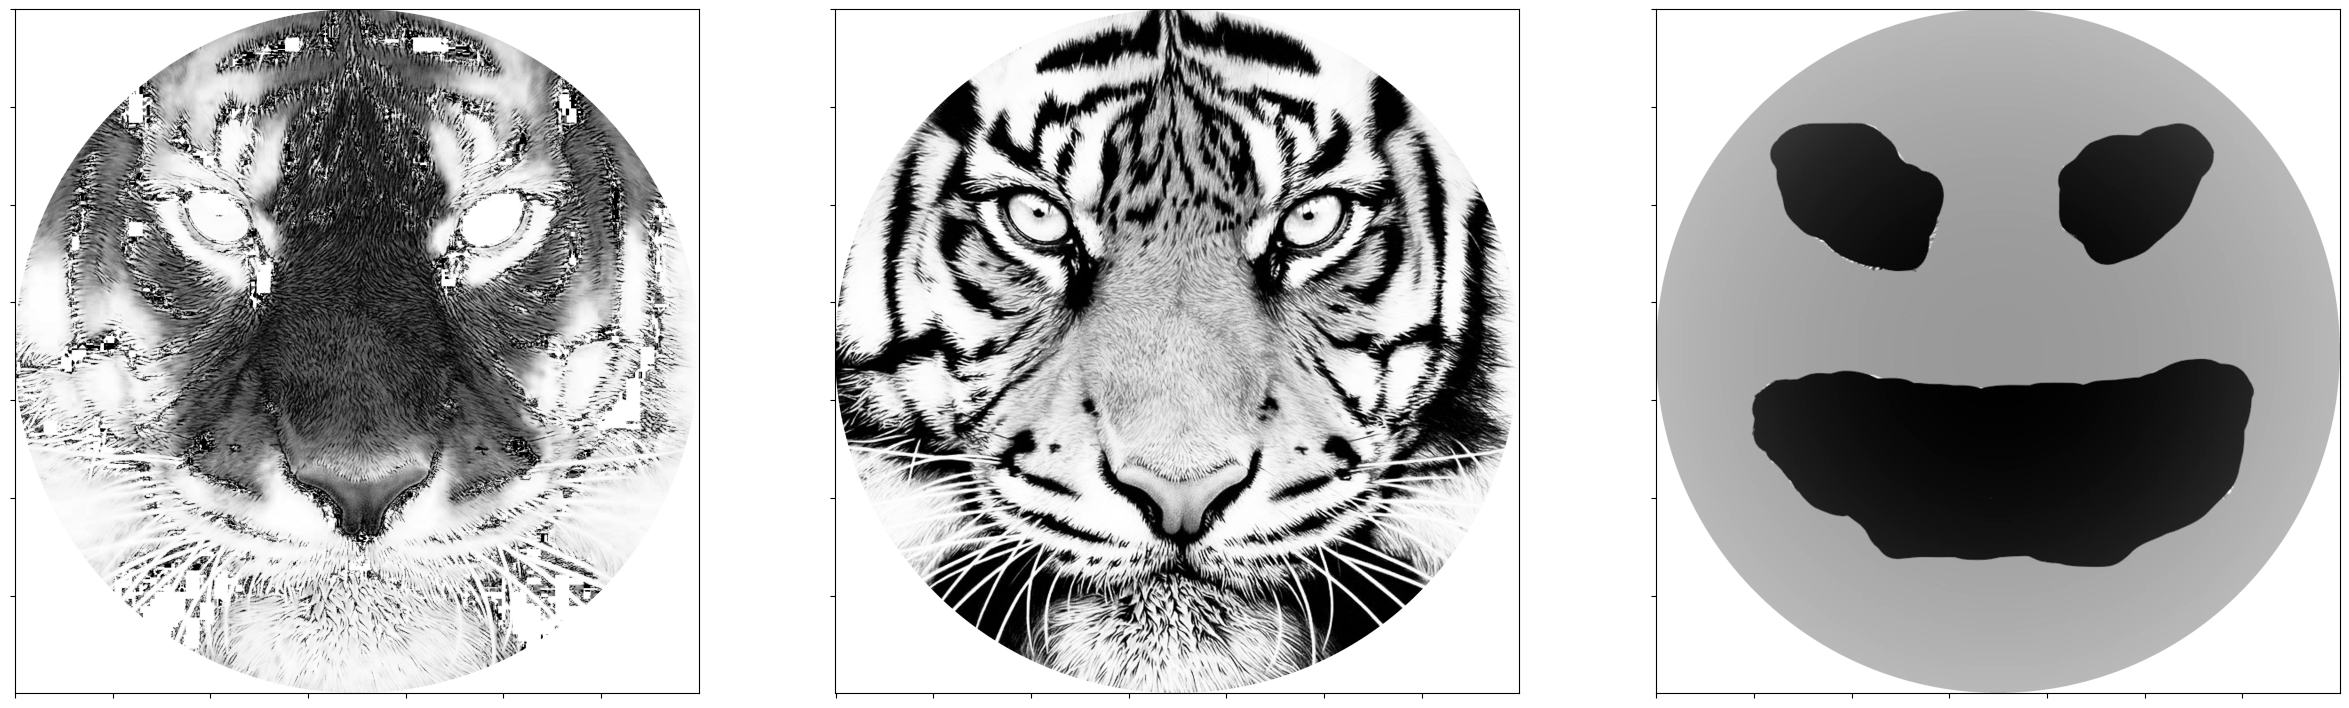

In [ ]:
image_list = [image_ORANGE, image_BLACK, image_w]
display_images(image_list)

In [ ]:
save_plot_progress([lines_ORANGE], [(255,130,0)], "tiger orange output", 3500, [0.25, 0.5, 0.75, 1])
save_plot_progress([lines_ORANGE, lines_BLACK], [(255,130,0), (0,0,0)], "tiger output", 3500, [0.2, 0.4, 0.6, 0.8, 1])
save_plot([lines_ORANGE, lines_BLACK], [(255,130,0), (0,0,0)], "tiger output", 3500)

[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]
[[ 0.22061374 -0.16543508]
 [ 1.21538559 -0.12604606]
 [ 0.05480492  0.79124056]]


In [ ]:
total_distance(lines_ORANGE)
total_distance(lines_BLACK)

distance = 54 meters
distance = 168 meters


In [ ]:
display_output(lines_ORANGE)
display_output(lines_BLACK)

30-1
128-0
32-0
16-0
22-1
35-0
19-0
9-1
17-1
40-0
12-1
134-0
19-1
30-1
17-1
30-1
16-0
34-0
21-0
1-0
28-1
17-1
37-1
16-0
134-1
39-1
3-0
17-0
25-0
127-1
14-0
38-1
13-0
1-1
37-0
5-1
133-1
2-1
12-1
23-1
43-0
34-1
23-1
13-0
24-1
9-0
135-0
11-1
35-1
17-1
5-1
15-1
26-1
35-1
7-0
32-0
15-1
135-0
35-1
18-0
37-0
15-0
0-1
34-0
7-1
25-0
0-0
22-1
37-0
7-0
32-0
14-1
19-1
1-0
38-0
4-0
36-1
19-0
31-0
23-0
5-1
38-1
0-0
10-0
40-1
5-0
0-0
23-0
37-1
4-1
134-0
24-1
29-1
13-0
41-1
21-1
42-1
134-0
35-1
27-1
134-0

100

36-0
17-0
38-1
17-1
5-1
18-1
11-0
42-0
31-1
13-0
32-0
7-1
37-1
31-1
10-1
0-1
33-1
27-0
127-1
13-0
3-1
25-0
40-1
34-0
13-1
7-0
19-0
14-0
20-1
1-1
19-0
11-0
2-0
40-0
3-0
35-1
41-1
14-0
28-0
16-1
31-0
40-1
17-0
34-1
25-0
8-1
133-1
7-0
42-0
33-1
21-1
26-1
17-1
35-1
1-0
8-0
3-0
134-0
37-1
9-0
15-0
40-0
13-0
0-0
28-0
134-1
9-0
31-1
3-1
22-0
1-1
43-0
32-0
133-1
5-1
35-0
25-0
40-0
27-0
4-0
41-1
31-0
4-0
18-1
2-1
41-0
15-1
9-1
36-0
11-1
30-0
43-0
36-1
0-1
14-1
134-0
19-1
1-1
30-0
8-1

200

17-1
39-1
11-